> Title: Dreamville Album Release Analysis for the Coming Quarter <br>
> Author: Katiyoun Raissi <br>
> Date: Winter Quarter 2020 <br>

# Table of Contents<a id="Top"></a>

1. [Problem Statement](#1)<br>
2. [Data](#2) <br>
    2.1 [Data Source](#2.1)<br>
    2.2 [Data Processing](#2.2)<br>
3. [Model Definition](#3)<br>
4. [Model Solution](#4)<br>
5. [Sensitivity Analysis](#5)<br>
    5.1 [Staffing Constraints](#5.1)<br>
    5.2 [Budget Constraints](#5.2)<br>
    5.3 [Producer Constraints](#5.3)<br>
    5.4 [Sensitivity Findings](#5.4)<br>
6. [Conclusions](#6)<br>
    6.1 [Tactical Information](#6.1)<br>
    6.2 [Strategic Information](#6.2)<br>
7. [Model Limitations, Future Improvements and Challenges](#7) <br>

# 1. Problem Statement<a id=1></a>

Recently, Dreamvile records was set to release 8 different albums for their various artisits. Due to the growing concerns of the corona virus, budgets cuts were made and staffing restrictions were implemented to comply with CDC regulations. Artists were asked to state the minimum number of team members they needed to complete their albums while executives limited the budget for the coming quarter. The new budget and staffing constraints also limited the producers available. Since Bas and Omen work with the same producer, only one can release an album. Ari Lennox's producer will not return for the quarter, and will only release her album is JCole is the producer (Note: to do so, JCole must finish his album). Below is the processes used in determining which albums to release given the $1,500,000 budget constraint, the CDC suggestion limiting 50 people to a confined space, and the various producer constraints.

The goal of the analysis was to maximize profit.

Further analysis was also done to deal with possible changing CDC suggestions, executive decisions regarding the budget, and producer constraints.

##### [Back to Top](#Top)

# 2. Data<a id=2></a>

The following section is with regards to the data used in the analysis. More specifically, it outlines data sourcing, data processing, and provides visuals for better understanding of the parameters used in the analysis.

## 2.1 Data Source<a id=2.1></a>

Data was taken from company memos, executive meetings, artists' surverys, and the budget department at Dreamvile. All the data was compiled into an excel workbook titled "DreamvilleAlbums".

For further details about data sourcing or copies of the information used please email Katiyoun Raissi: kraissi@dreamvillerecords.com

## 2.2 Data Processing<a id=2.2></a>

In [1]:
##imports the necessary dataframe package pandas as pd 
##reads in the excel "DreamvilleAlbums" specified as data
import pandas as pd 
data=pd.read_excel("DreamvilleAlbums.xlsx", sheet_name ='DreamvilleAlbums')

In [2]:
##creates a dataframe with revenue, expense, and staff attributes for each artist
coef = pd.DataFrame(data.iloc[1:4, 1:9])
coef.index = ['revenue','expense', 'staff']
coef.columns = ['JCole', 'JID', 'Bas','EarthGang','Ari Lennox', 'Lute', 'Cozz', 'Omen']
coef

,JCole,JID,Bas,EarthGang,Ari Lennox,Lute,Cozz,Omen
revenue,483696,624782,634391,580575,533692,497223,605216,647742
expense,285652,346064,296491,305795,335092,328847,328898,259612
staff,11,11,7,5,9,7,10,9


In [3]:
##imports the necessary dataframe packages: numpy as np, seaborn as sns, and matplotlib.pyplot as plt
##sets the style of the bar graph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")

##sets up the matplotlib figure
##specifies the figure size and restricts the x-axis to the artists and the y-axis to USD money
f, ax = plt.subplots(figsize=(20, 10), sharey=True, sharex=True)
ax.set_ylabel("Money (USD)")
ax.set_xlabel("Artist")

##creates the barplots
sns.barplot(x=coef.columns, y=list(coef.loc['revenue']), color='olivedrab')
sns.barplot(x=coef.columns, y=list(coef.loc['expense']), color='darkkhaki')
                        

In [4]:
##creates a dataframe with all the constraints previously stated in the Problem Statement
rhs = pd.DataFrame(data.iloc[10:12, 12])
rhs.index = list(coef.index[1:])
rhs.columns = ['rhs']
rhs

,rhs
expense,1500000.0
staff,50.0


##### [Back to Top](#Top)

# 3. Model Definition<a id=3><a>

The following section is with regards to the model used in the analysis. More specifically, it instantiates the model, creates the decision index, and solves the model with the given constraints. Specific notes and processes can be found as commnets in the code.

In [5]:
##imports the optimization package pyomo as pe
##instantiates a ConcreteModel and stores it in the variable `model`
import pyomo.environ as pe
model = pe.ConcreteModel()

##creates variable `x` with domain of binary decisions 
decision_index = list(range(8))
model.x = pe.Var(decision_index, domain=pe.Binary)

##defines profit as the revenue-expense of each album
model.obj = pe.Objective(expr=sum([coef.iloc[0, i]*model.x[i] for i in decision_index])
                         - sum([coef.iloc[1, i]*model.x[i] for i in decision_index]), sense=-1)

##creates expense and staffing constraints
model.cons_expenses = pe.Constraint(expr=sum([coef.iloc[1, i]*model.x[i] for i in decision_index]) <= rhs.loc['expense', 'rhs'])
model.cons_staff = pe.Constraint(expr=sum([coef.iloc[2, i]*model.x[i] for i in decision_index]) <= rhs.loc['staff', 'rhs'])

##creates producer constraints
model.cons_BasOmen = pe.Constraint(expr=model.x[2]+model.x[7] <=1)
model.cons_AriContJCole = pe.Constraint(expr=model.x[0]-model.x[4] >=0)

##runs solver
opt = pe.SolverFactory('glpk')
success = opt.solve(model, tee=False)


##### [Back to Top](#Top)

# 4. Model Solution<a id=4></a>

The following section outlines the findings of the model. 

In [6]:
obj_val = model.obj.expr()
print(f'Expected profit for Q3: $ {obj_val}')

artists = ['JCole','JID','Bas','EarthGang','Ari Lennox','Lute','Cozz','Omen']
x = []
for index in model.x_index.value_list:
    x.append(model.x[index].value)
num_a=sum(x)
print(f'Expected number of albums: {num_a}')
print(f'Expenses slack = {model.cons_expenses.slack()}')
print(f'Staff slack = {model.cons_staff.slack()}')
df = pd.DataFrame(x, index=artists, columns=['Album']) 
df.replace([1,0],['Yes','No'])

Expected profit for Q3: $ 1217946.0
Expected number of albums: 4.0
Expenses slack = 259631.0
Staff slack = 15.0


,Album
JCole,No
JID,Yes
Bas,No
EarthGang,Yes
Ari Lennox,No
Lute,No
Cozz,Yes
Omen,Yes


The maximum profit for the coming quarter is 1,217,946.00 with only four artists set to release albums: JID, EarthGang, Cozz, and Omen. Given the current model, Dreamville would be $259,631 below the budget and have room for 15 more staff members under the current CDC recommendation. Per the producer constraints, Ari Lennox did not release an album as JCole did not and Omen released an album while Bas did not either. 

##### [Back to Top](#Top)

# 5. Sensitivity Analysis<a id=5></a>

## 5.1 Staffing Constraints<a id=5.1></a>

In [7]:
##runs a model for new staff constraint of 30
model = pe.ConcreteModel()

##creates variable `x` with domain of binary decisions 
decision_index = list(range(8))
model.x = pe.Var(decision_index, domain=pe.Binary)

##defines profit as the revenue-expense of each album
model.obj = pe.Objective(expr=sum([coef.iloc[0, i]*model.x[i] for i in decision_index])
                         - sum([coef.iloc[1, i]*model.x[i] for i in decision_index]), sense=-1)

##creates expense and staffing constraints
model.cons_expenses = pe.Constraint(expr=sum([coef.iloc[1, i]*model.x[i] for i in decision_index]) <= rhs.loc['expense', 'rhs'])
model.cons_staff = pe.Constraint(expr=sum([coef.iloc[2, i]*model.x[i] for i in decision_index]) <= 30)

##creates producer constraints
model.cons_BasOmen = pe.Constraint(expr=model.x[2]+model.x[7] <=1)
model.cons_AriContJCole = pe.Constraint(expr=model.x[0]-model.x[4] >=0)

##runs solver
opt = pe.SolverFactory('glpk')
success = opt.solve(model, tee=False)

obj_val = model.obj.expr()
print(f'Expected profit for Q3: $ {obj_val}')

artists = ['JCole','JID','Bas','EarthGang','Ari Lennox','Lute','Cozz','Omen']
x = []
for index in model.x_index.value_list:
    x.append(model.x[index].value)
num_a=sum(x)
print(f'Expected number of albums: {num_a}')
print(f'Expenses slack = {model.cons_expenses.slack()}')
print(f'Staff slack = {model.cons_staff.slack()}')
df = pd.DataFrame(x, index=artists, columns=['Album']) 
df.replace([1,0],['Yes','No'])

Expected profit for Q3: $ 1059774.0
Expected number of albums: 4.0
Expenses slack = 222803.0
Staff slack = 0.0


,Album
JCole,No
JID,Yes
Bas,Yes
EarthGang,Yes
Ari Lennox,No
Lute,Yes
Cozz,No
Omen,No


In [8]:
##runs a model for new staff constraint of 10
model = pe.ConcreteModel()

##creates variable `x` with domain of binary decisions 
decision_index = list(range(8))
model.x = pe.Var(decision_index, domain=pe.Binary)

##defines profit as the revenue-expense of each album
model.obj = pe.Objective(expr=sum([coef.iloc[0, i]*model.x[i] for i in decision_index])
                         - sum([coef.iloc[1, i]*model.x[i] for i in decision_index]), sense=-1)

##creates expense and staffing constraints
model.cons_expenses = pe.Constraint(expr=sum([coef.iloc[1, i]*model.x[i] for i in decision_index]) <= rhs.loc['expense', 'rhs'])
model.cons_staff = pe.Constraint(expr=sum([coef.iloc[2, i]*model.x[i] for i in decision_index]) <= 10)

##creates producer constraints
model.cons_BasOmen = pe.Constraint(expr=model.x[2]+model.x[7] <=1)
model.cons_AriContJCole = pe.Constraint(expr=model.x[0]-model.x[4] >=0)

##runs solver
opt = pe.SolverFactory('glpk')
success = opt.solve(model, tee=False)

obj_val = model.obj.expr()
print(f'Expected profit for Q3: $ {obj_val}')

artists = ['JCole','JID','Bas','EarthGang','Ari Lennox','Lute','Cozz','Omen']
x = []
for index in model.x_index.value_list:
    x.append(model.x[index].value)
num_a=sum(x)
print(f'Expected number of albums: {num_a}')
print(f'Expenses slack = {model.cons_expenses.slack()}')
print(f'Staff slack = {model.cons_staff.slack()}')
df = pd.DataFrame(x, index=artists, columns=['Album']) 
df.replace([1,0],['Yes','No'])

Expected profit for Q3: $ 388130.0
Expected number of albums: 1.0
Expenses slack = 1240388.0
Staff slack = 1.0


,Album
JCole,No
JID,No
Bas,No
EarthGang,No
Ari Lennox,No
Lute,No
Cozz,No
Omen,Yes


Text(0, 0.5, 'Number of Albums')

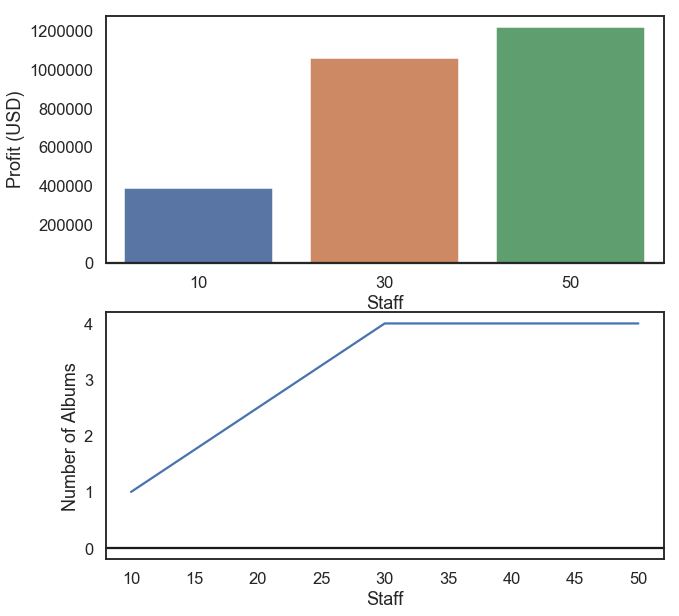

In [9]:
data = {'Staff': [50, 30, 10],'Profit (USD)': [1217946, 1059774, 388130],'Number of Albums':[4,4,1]}
df = pd.DataFrame(data,columns=['Staff',  'Profit (USD)','Number of Albums'])
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Generate some sequential data
sns.barplot(x="Staff", y="Profit (USD)", data=df, ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Profit (USD)")

# Center the data to make it diverging
sns.lineplot(x="Staff", y="Number of Albums", data=df, ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Number of Albums")

## 5.2 Budget Constraints<a id=5.2></a>

In [10]:
##runs a model for new budget of $2,000,000
model = pe.ConcreteModel()

##creates variable `x` with domain of binary decisions 
decision_index = list(range(8))
model.x = pe.Var(decision_index, domain=pe.Binary)

##defines profit as the revenue-expense of each album
model.obj = pe.Objective(expr=sum([coef.iloc[0, i]*model.x[i] for i in decision_index])
                         - sum([coef.iloc[1, i]*model.x[i] for i in decision_index]), sense=-1)

##creates expense and staffing constraints
model.cons_expenses = pe.Constraint(expr=sum([coef.iloc[1, i]*model.x[i] for i in decision_index]) <= 2000000)
model.cons_staff = pe.Constraint(expr=sum([coef.iloc[2, i]*model.x[i] for i in decision_index]) <= rhs.loc['staff', 'rhs'])

##creates producer constraints
model.cons_BasOmen = pe.Constraint(expr=model.x[2]+model.x[7] <=1)
model.cons_AriContJCole = pe.Constraint(expr=model.x[0]-model.x[4] >=0)

##runs solver
opt = pe.SolverFactory('glpk')
success = opt.solve(model, tee=False)

obj_val = model.obj.expr()
print(f'Expected profit for Q3: $ {obj_val}')

artists = ['JCole','JID','Bas','EarthGang','Ari Lennox','Lute','Cozz','Omen']
x = []
for index in model.x_index.value_list:
    x.append(model.x[index].value)
num_a=sum(x)
print(f'Expected number of albums: {num_a}')
print(f'Expenses slack = {model.cons_expenses.slack()}')
print(f'Staff slack = {model.cons_staff.slack()}')
df = pd.DataFrame(x, index=artists, columns=['Album']) 
df.replace([1,0],['Yes','No'])

Expected profit for Q3: $ 1456418.0
Expected number of albums: 6.0
Expenses slack = 102059.0
Staff slack = 0.0


,Album
JCole,Yes
JID,Yes
Bas,Yes
EarthGang,Yes
Ari Lennox,Yes
Lute,Yes
Cozz,No
Omen,No


238472


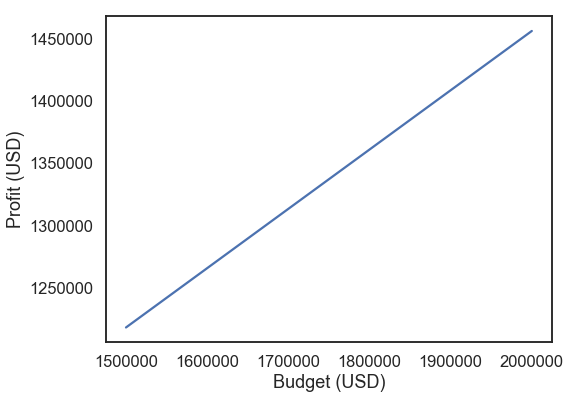

In [11]:
data = {'Budget (USD)': [1500000, 2000000],'Profit (USD)': [1217946, 1456418],'Number of Albums':[4,6]}
df = pd.DataFrame(data,columns=['Budget (USD)',  'Profit (USD)','Number of Albums'])

f, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x="Budget (USD)", y="Profit (USD)", data=df)
print(1456418-1217946)

## 5.3 Producer Constraints<a id=5.3></a>

In [12]:
##runs a model assuming Bas and Omen both have time with the producer
model = pe.ConcreteModel()

##creates variable `x` with domain of binary decisions 
decision_index = list(range(8))
model.x = pe.Var(decision_index, domain=pe.Binary)

##defines profit as the revenue-expense of each album
model.obj = pe.Objective(expr=sum([coef.iloc[0, i]*model.x[i] for i in decision_index])
                         - sum([coef.iloc[1, i]*model.x[i] for i in decision_index]), sense=-1)

##creates expense and staffing constraints
model.cons_expenses = pe.Constraint(expr=sum([coef.iloc[1, i]*model.x[i] for i in decision_index]) <= rhs.loc['expense', 'rhs'])
model.cons_staff = pe.Constraint(expr=sum([coef.iloc[2, i]*model.x[i] for i in decision_index]) <= rhs.loc['staff', 'rhs'])

##creates producer constraints
model.cons_AriContJCole = pe.Constraint(expr=model.x[0]-model.x[4] >=0)

##runs solver
opt = pe.SolverFactory('glpk')
success = opt.solve(model, tee=False)

obj_val = model.obj.expr()
print(f'Expected profit for Q3: $ {obj_val}')

artists = ['JCole','JID','Bas','EarthGang','Ari Lennox','Lute','Cozz','Omen']
x = []
for index in model.x_index.value_list:
    x.append(model.x[index].value)
num_a=sum(x)
print(f'Expected number of albums: {num_a}')
print(f'Expenses slack = {model.cons_expenses.slack()}')
print(f'Staff slack = {model.cons_staff.slack()}')
df = pd.DataFrame(x, index=artists, columns=['Album']) 
df.replace([1,0],['Yes','No'])

Expected profit for Q3: $ 1477572.0
Expected number of albums: 5.0
Expenses slack = 6386.0
Staff slack = 7.0


,Album
JCole,Yes
JID,Yes
Bas,Yes
EarthGang,Yes
Ari Lennox,No
Lute,No
Cozz,No
Omen,Yes


## 5.4 Sensitivity Findings<a id=5.3></a>

In [13]:
data = {'Constraints':['Original Model','Staff of 30', 'Staff of 10', 'Increase of Budget to $2,000,000', 'Enabling Producers'],'Profit (USD)': [1217946, 1059774,388130,1456418,1477572],'Number of Albums':[4,4,1,6,5], 'Expenses Slack':[259631,222803,1240388,102059,6386], 'Staff Slack':[15,0,1,0,7]}
df = pd.DataFrame(data,columns=['Constraints','Profit (USD)','Number of Albums','Expenses Slack','Staff Slack'])
df

,Constraints,Profit (USD),Number of Albums,Expenses Slack,Staff Slack
0,Original Model,1217946,4,259631,15
1,Staff of 30,1059774,4,222803,0
2,Staff of 10,388130,1,1240388,1
3,"Increase of Budget to $2,000,000",1456418,6,102059,0
4,Enabling Producers,1477572,5,6386,7


Text(0.5, 0, 'Constraint')

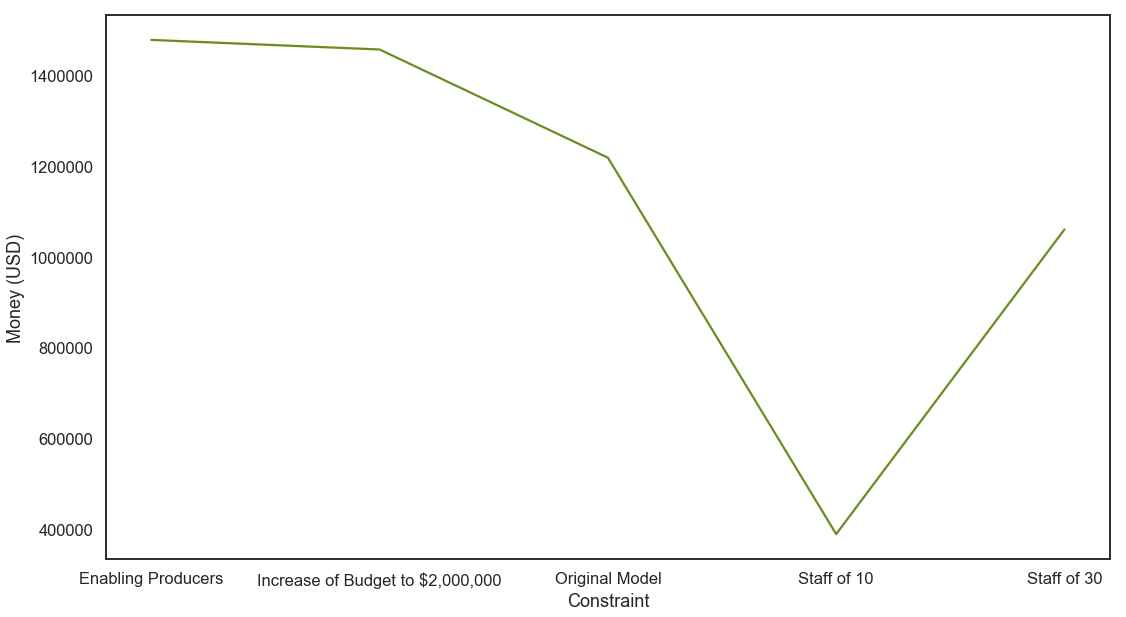

In [14]:
##sets up the matplotlib figure
##specifies the figure size and restricts the x-axis to the artists and the y-axis to USD money
f, ax = plt.subplots(figsize=(18, 10), sharex=True)

##creates the barplots
sns.lineplot(x=df['Constraints'], y=df['Profit (USD)'], color='olivedrab')

ax.set_ylabel("Money (USD)")
ax.set_xlabel("Constraint")

After running several models and scenarios, the biggest constraint effecting profits was the producers constraint. After enabling Bas and Omen to both release albums, profit grew by 259,626 (USD) from the original model. Five albums would be produced and Dreamville would only have a surplus of 7 staff members. The total cost of the releasing these albums would also be 6386 (USD) below the budget as well. The possible CDC suggestion of 10 members produced the lowest for Dreamville. Although the scenario still return a profit of 388,130 (USD), the profit was 829,816 (USD) below the original model. Only one album would released and there would be only a staff surplus of 1 under a possible CDC suggestion of 10 staff members. The production expenses of this scenario would be 1,240,388 (USD) below the budget. 

##### [Back to Top](#Top)

# 6. Conclusions<a id=6></a>

## 6.1 Tactical Information<a id=6.1></a>

As stated previously, the maximum profit for the coming quarter is 1,217,946 (USD) with only four artists set to release albums: JID, EarthGang, Cozz, and Omen. Given the current model, Dreamville would be 259,631 (USD) below the budget and have room for 15 more staff members under the CDC recommendation. Per the producer constraints, Ari Lennox did not release an album as JCole did not and Omen released an album while Bas did not.

## 6.2 Strategic Information<a id=6.2></a>

After running several models and scenarios, the biggest constraint effecting profits was the producers constraint. After enabling Bas and Omen to both release albums, profit grew by 259,626 (USD) from the original model. Five albums would be produced and Dreamville would only have a surplus of 7 staff members. The total cost of the releasing these albums would also be 6386 (USD) below the budget as well. The possible CDC suggestion of 10 members produced the lowest for Dreamville. Although the scenario still return a profit of 388,130 (USD), the profit was 829,816 (USD) below the original model. Only one album would released and there would be only a staff surplus of 1 under a possible CDC suggestion of 10 staff members. The production expenses of this scenario would be 1,240,388 (USD) below the budget.

It is interesting to note that the budget increase to 2,000,000 (USD) did not produce the maximum profit. Profit would increase by 238,472 (USD) from the original model but would below 21,154(USD) from the model enabling Bas and Omen to both release albums. By increasing the budget to 2,000,000 (USD), 6 albums would be released and all staff would be used. 

The recommendation moving forward would be to enable Omen and Bas to both release albums. Getting different producers that each  artist can work with or allocating time with each their shared producer would return the greatest profit for Dreamville. 

##### [Back to Top](#Top)

# 7. Model Limitations, Future Improvements and Challenges<a id=7></a>

The models created above have several limitations. Every artist has a different number of needed staff for their album releases. The decrease of staff, therefore, cannot be linearly understood. The same observation can be made for the budget constraint and the producer constraints. Running each scenario would allow a more wholistic perspective of the constraints and their effect of profits. As far as analysis and execution, an Abstract model would better provide insight and granularity than that of a Concrete model used above. 

Furthermore, all expense and revenue parameters were taken before the Corona outbreak and could therefore be flawed. No new analysis was taken in the current weeks of the outbreak but instead were given with trends of years past. The model then is as good as the data provided.  

##### [Back to Top](#Top)